# Import required libraries

In [11]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [12]:
torch.cuda.synchronize()

# Custom Dataset Definition

In [13]:
# Defines a PyTorch dataset for handling images and their corresponding labels.
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data Loading and Preprocessing

In [14]:
# Initialize variables for storing images and labels and define categories.
X = []
y = []
image_size = 150
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

Load Training Data

In [15]:
# Load and preprocess training images by resizing and converting to RGB.
for i, label in enumerate(labels):
    folderPath = os.path.join('Brain Tumor\Training', label)
    for filename in os.listdir(folderPath):
        img_path = os.path.join(folderPath, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(i)

Load Testing Data

In [16]:
for i, label in enumerate(labels):
    folderPath = os.path.join('Brain Tumor\Testing', label)
    for filename in os.listdir(folderPath):
        img_path = os.path.join(folderPath, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(i)

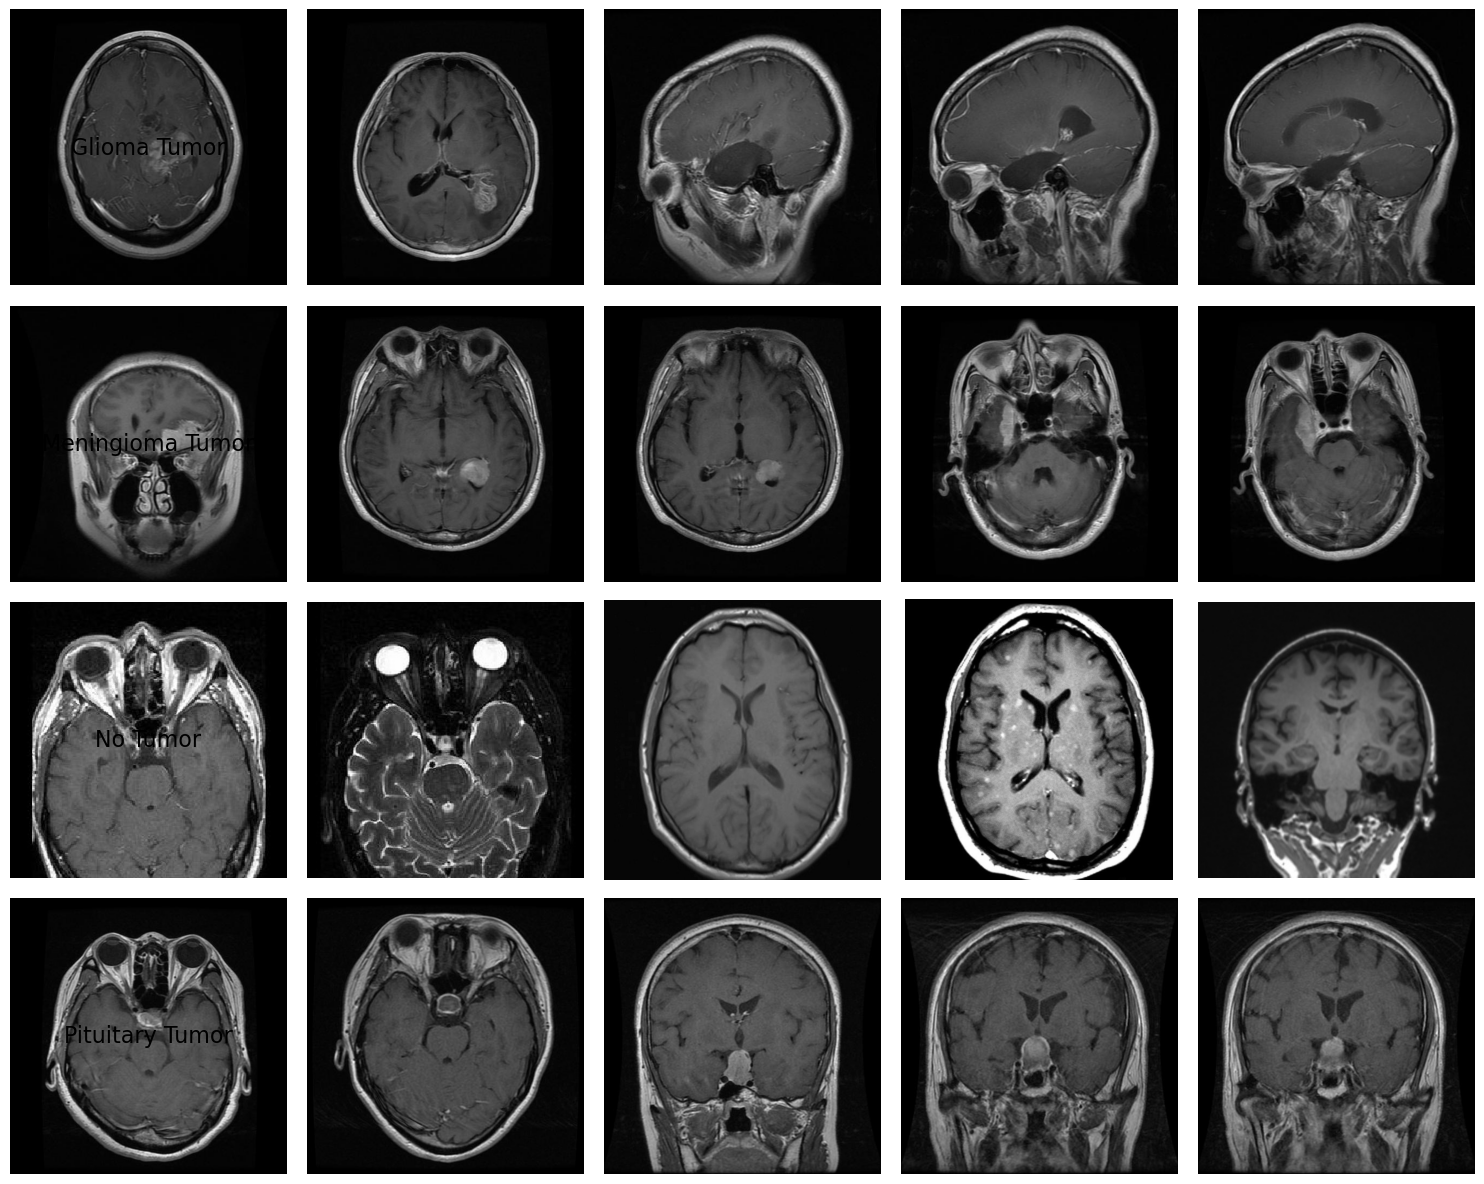

In [17]:
import os
import cv2
import matplotlib.pyplot as plt

def visualize_images_with_titles(dataset_dir, class_names, num_images=5):
    
    plt.figure(figsize=(num_images * 3, len(class_names) * 3)) 

    for row_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_dir, class_name)
        try:
            image_files = os.listdir(class_path)[:num_images]  

            plt.subplot(len(class_names), num_images, row_idx * num_images + 1)
            plt.text(0.5, 0.5, class_name.replace("_", " ").title(), fontsize=16,
                     ha='center', va='center', transform=plt.gca().transAxes)
            plt.axis("off")

            for col_idx, img_file in enumerate(image_files):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

                plt.subplot(len(class_names), num_images, row_idx * num_images + col_idx + 1)
                plt.imshow(img)
                plt.axis("off")

        except FileNotFoundError:
            print(f"Directory not found: {class_path}")

    plt.tight_layout()
    plt.show()

testing_dataset_dir = "Brain Tumor\Training" 
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

visualize_images_with_titles(testing_dataset_dir, class_labels)

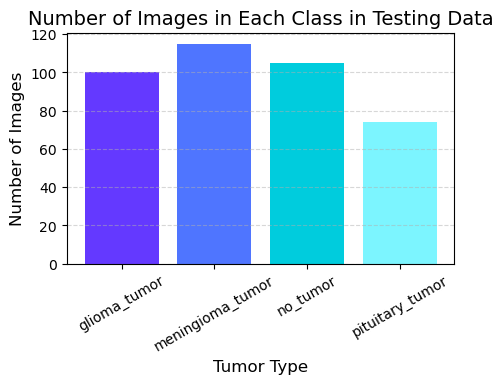

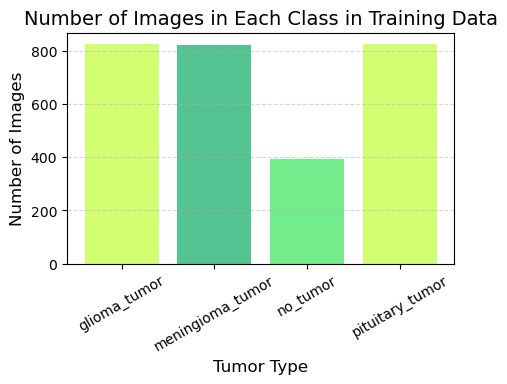

In [18]:
import os
import matplotlib.pyplot as plt

def plot_category_image_counts(dataset_dir, class_names):
    counts = []
    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        try:
            num_images = len(os.listdir(class_path))
            counts.append(num_images)
        except FileNotFoundError:
            print(f"Directory not found: {class_path}")
            counts.append(0) 

    plt.figure(figsize=(5, 3))
    plt.bar(class_names, counts, color=['#6439FF', '#4F75FF', '#00CCDD', '#7CF5FF'])
    plt.title("Number of Images in Each Class in Testing Data", fontsize=14)
    plt.xlabel("Tumor Type", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=30)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

testing_dataset_dir = "Brain Tumor\Testing"  
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

plot_category_image_counts(testing_dataset_dir, class_labels)

def plot_category_image_counts(dataset_dir, class_names):
    counts = []
    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        try:
            num_images = len(os.listdir(class_path))
            counts.append(num_images)
        except FileNotFoundError:
            print(f"Directory not found: {class_path}")
            counts.append(0) 

    plt.figure(figsize=(5, 3))
    plt.bar(class_names, counts, color=['#D2FF72', '#54C392', '#73EC8B', '#D2FF72'])
    plt.title("Number of Images in Each Class in Training Data", fontsize=14)
    plt.xlabel("Tumor Type", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=30)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

training_dataset_dir = "Brain Tumor\Training"  
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

plot_category_image_counts(training_dataset_dir, class_labels)


Convert and Shuffle Data

In [27]:
X = np.array(X)
y = np.array(y)

Convert lists to arrays and shuffle for randomness in training.

In [28]:
X, y = shuffle(X, y, random_state=42)

# Train-Validation-Test Split

In [29]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create PyTorch Datasets and DataLoaders

In [30]:
# Wrap datasets with transformations and prepare DataLoader for batching.

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [31]:
train_dataset = BrainTumorDataset(X_train, y_train, transform=transform)
val_dataset = BrainTumorDataset(X_val, y_val, transform=transform)
test_dataset = BrainTumorDataset(X_test, y_test, transform=transform)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

batch_size = number of training examples used in one forward and backward pass during the training of a model.

# CNN Model Definition

In [33]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()     #Calls the parent class's initializer to ensure proper initialization of the module.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * (image_size // 16) * (image_size // 16), 256)
        self.fc2 = nn.Linear(256, len(labels))
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Defines the first 2D convolutional layer:
3: Input channels (3 for RGB images).
32: Number of output feature maps.
kernel_size=3: Size of the convolutional filter (3x3).
stride=1: Filter moves 1 pixel at a time.
padding=1: Adds a 1-pixel border to maintain the same output size as input.

Second convolutional layer:
32: Input channels from the previous layer.
64: Number of output feature maps.

Defines a 2D max-pooling layer:
kernel_size=2: Reduces spatial dimensions by taking the maximum value in each 2x2 window.
stride=2: Pooling window moves 2 pixels at a time.
padding=0: No additional padding is applied.

First fully connected layer:
Input size:
The feature map size is reduced by max-pooling applied after each convolution (4 layers of 2x2 pooling = 
2^4=16=16).
image_size // 16: Final spatial dimensions after pooling.
128: Number of channels from the last convolutional layer.
Output size: 256 neurons.

0.3: Randomly drops 30% of neurons during training to reduce overfitting.

conv1: Applies the first convolution.
relu: Activates non-linearities.
pool: Reduces the spatial size using max-pooling.

Initialize Model, Loss, Optimizer, and Scheduler

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss() # Specifies the loss function to use during training.
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # or SGD with 0.01
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.6)

Defines the optimizer, which updates the model's parameters dynamically to minimize the loss during training. 

gamma=0.5: The learning rate will be multiplied by 0.5 times every 5 epochs(step_size)


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if torch.cuda.is_available():
    print(f"Model successfully moved to the GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Model is using the CPU")

Model successfully moved to the GPU: NVIDIA GeForce RTX 3050 Laptop GPU


# Model Training and Validation

In [36]:
num_epochs = 20
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
patience = 5      # Number of epochs to wait before stopping if validation loss doesn't improve.
best_val_loss = float('inf')  # Tracks the best (lowest) validation loss seen so far.

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        # Ensure labels are of type LongTensor
        images, labels = images.to(device), labels.long().to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")   # Prevents overfitting and saves training time if the model's validation performance stagnates.
            break
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/20 | Train Loss: 1.2497 | Train Acc: 0.4194 | Val Loss: 1.0566 | Val Acc: 0.6074
Epoch 2/20 | Train Loss: 0.9452 | Train Acc: 0.6132 | Val Loss: 0.8614 | Val Acc: 0.6902
Epoch 3/20 | Train Loss: 0.7686 | Train Acc: 0.6745 | Val Loss: 0.7316 | Val Acc: 0.7025
Epoch 4/20 | Train Loss: 0.6343 | Train Acc: 0.7480 | Val Loss: 0.6439 | Val Acc: 0.7761
Epoch 5/20 | Train Loss: 0.5685 | Train Acc: 0.7863 | Val Loss: 0.5923 | Val Acc: 0.7914
Epoch 6/20 | Train Loss: 0.4770 | Train Acc: 0.8131 | Val Loss: 0.5487 | Val Acc: 0.8190
Epoch 7/20 | Train Loss: 0.3899 | Train Acc: 0.8445 | Val Loss: 0.4797 | Val Acc: 0.8374
Epoch 8/20 | Train Loss: 0.3752 | Train Acc: 0.8525 | Val Loss: 0.4899 | Val Acc: 0.8252
Epoch 9/20 | Train Loss: 0.3171 | Train Acc: 0.8801 | Val Loss: 0.4436 | Val Acc: 0.8650
Epoch 10/20 | Train Loss: 0.2840 | Train Acc: 0.8928 | Val Loss: 0.4486 | Val Acc: 0.8528
Epoch 11/20 | Train Loss: 0.2329 | Train Acc: 0.9138 | Val Loss: 0.3951 | Val Acc: 0.8804
Epoch 12/20 | Train

# Visualization

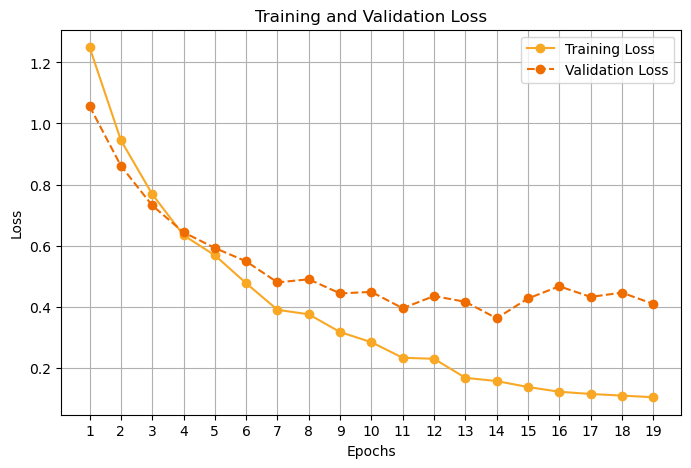

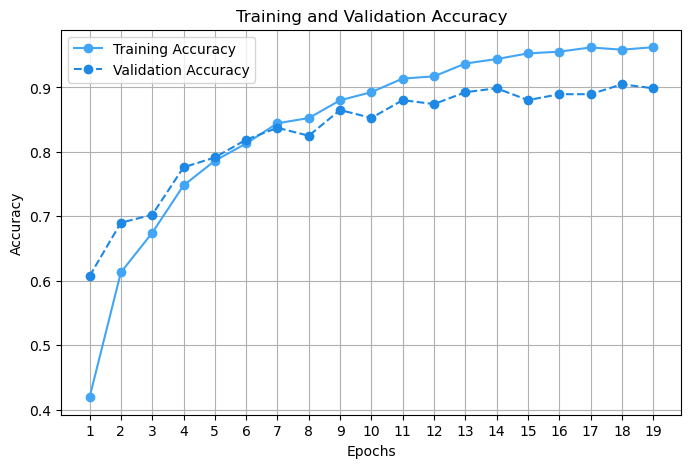

In [37]:
# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, 'o-', color='#f9a825', label='Training Loss')  # Yellow color
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'o--', color='#ef6c00', label='Validation Loss')  # Orange color
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_loss_history) + 1))  # Show every epoch
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, 'o-', color='#42a5f5', label='Training Accuracy')  # Blue color
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, 'o--', color='#1e88e5', label='Validation Accuracy')  # Darker blue color
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(train_acc_history) + 1))  # Show every epoch
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [38]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Display metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1-Score: {f1:.4f}')

Test Accuracy: 0.9052
Test Precision: 0.9085
Test Recall: 0.9052
Test F1-Score: 0.9042


# Prediction

C:\Users\freel\AppData\Local\Temp\ipykernel_20072\2614236729.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load the 

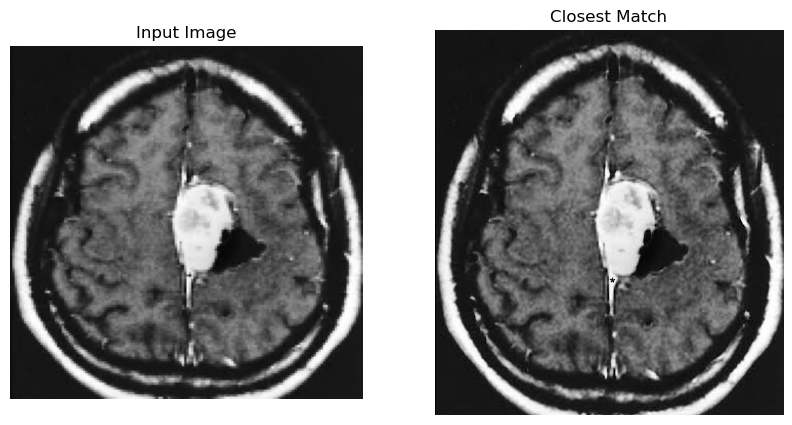

Tumor Detected!
Tumor Type: Meningioma Tumor


In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import os
import torch.nn as nn

# Define the CNNModel class
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * (150 // 16) * (150 // 16), 256)  # Assuming image size is 150x150
        self.fc2 = nn.Linear(256, 4)  # Output layer for 4 classes (adjust according to your actual output classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to compute feature vectors
def extract_features(model, image_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        features = model(image_tensor)
    return features

# Function to predict and find the closest match
def predict_and_match_image(input_image_path, root_folder, model, transform):
    # Load and preprocess the input image
    img = cv2.imread(input_image_path)
    if img is None:
        print("Invalid image path!")
        return
    img = cv2.resize(img, (150, 150))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # For display
    img_tensor = transform(img_rgb).unsqueeze(0)  # Add batch dimension

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    img_tensor = img_tensor.to(device)

    # Extract features for the input image
    input_features = extract_features(model, img_tensor).cpu().numpy()

    # Search all images in the root folder and subfolders
    training_image_paths = []
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                training_image_paths.append(os.path.join(dirpath, file))

    if not training_image_paths:
        print("No training images found in the folder or subfolders!")
        return

    # Compare input features with training data
    closest_match_path = None
    min_distance = float('inf')
    for train_image_path in training_image_paths:
        train_img = cv2.imread(train_image_path)
        if train_img is None:
            continue
        train_img = cv2.resize(train_img, (150, 150))
        train_img_rgb = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
        train_tensor = transform(train_img_rgb).unsqueeze(0)
        train_tensor = train_tensor.to(device)

        # Extract features for the training image
        train_features = extract_features(model, train_tensor).cpu().numpy()

        # Normalize the feature vectors 
        input_features_norm = input_features / np.linalg.norm(input_features)
        train_features_norm = train_features / np.linalg.norm(train_features)

        # Calculate Euclidean distance
        distance = np.linalg.norm(input_features_norm - train_features_norm)

        if distance < min_distance:
            min_distance = distance
            closest_match_path = train_image_path

    # Load the closest match image
    if closest_match_path:
        closest_image = cv2.imread(closest_match_path)
        closest_image = cv2.cvtColor(closest_image, cv2.COLOR_BGR2RGB)

        # Display the input image and closest match
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img_rgb)
        axes[0].set_title("Input Image")
        axes[0].axis('off')
        axes[1].imshow(closest_image)
        axes[1].set_title("Closest Match")
        axes[1].axis('off')
        plt.show()

        # Classify the input image using the model
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted_class = torch.max(output, 1)  # Get the class with the highest score

        tumor_types = ['Glioma Tumor', 'Meningioma Tumor', 'No Tumor', 'Pituitary Tumor']
        predicted_tumor = tumor_types[predicted_class.item()]

        if predicted_tumor != 'No Tumor':
            print("Tumor Detected!")
            print(f"Tumor Type: {predicted_tumor}")
        else:
            print("No Tumor Detected!")
    else:
        print("No matching image found!")

transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

model = CNNModel() 
model_path = "best_model.pth"  
model.load_state_dict(torch.load(model_path))  # Load the trained model weights

# Specify the root folder containing training images in subfolders
root_folder = "Brain Tumor/Training" 

# Input for the image path
input_image_path = input("Enter the path of the input image: ")

# Call the function to predict and match the image
predict_and_match_image(input_image_path, root_folder, model, transform)